In [1]:
import os
from glob import glob
import json
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import math
from torch import nn
from torch.nn.init import constant_, xavier_uniform_

np.set_printoptions(precision=4, suppress=True)


def apply_window(img, min_hu=0, max_hu=800):
    img = (img - min_hu) / (max_hu - min_hu)
    img[img > 1.0] = 1.0
    img[img < 0.0] = 0.0
    return img


def show(img):
    plt.close()
    plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap="gray")
    plt.show()

In [2]:
train_im_dir = "/work/vig/Datasets/aneurysm/internal_train"
test_im_dir = "/work/vig/Datasets/aneurysm/internal_test/crop_0.4"
train_mask_dir = "/work/vig/Datasets/aneurysm/internal_label_train"
test_mask_dir = "/work/vig/Datasets/aneurysm/internal_test/crop_0.4_label"
vessel_mask_test_dir = (
    "/home/ceballosarroyo.a/workspace/datasets/aneurysm/internal_train_0.4_crop_vessel"
)
val_box_path = (
    "/home/ceballosarroyo.a/workspace/medical/cta-det2/labels/internal_test_crop_0.4.csv"
)
train_im_files = sorted(list(glob(f"{train_im_dir}/*")))
val_im_files = sorted(list(glob(f"{test_im_dir}/*")))
train_mask_files = sorted(list(glob(f"{train_mask_dir}/*")))
test_mask_files = sorted(list(glob(f"{test_mask_dir}/*")))
test_vessel_mask_files = sorted(list(glob(f"{vessel_mask_test_dir}/*")))
len(train_im_files), len(val_im_files), len(train_mask_files), len(test_mask_files)

(0, 152, 1186, 152)

In [5]:
exp_name = "aeval_deform_decoder_only_rec_16_heads"
scanid = "Ts0007.nii.gz"

In [6]:
path_viz = f"/home/ceballosarroyo.a/workspace/medical/cta-det2/outputs/{exp_name}/{scanid}_viz.pkl"
path_res = f"/home/ceballosarroyo.a/workspace/medical/cta-det2/outputs/{exp_name}/{scanid}_res.pkl"
path_splits = f"/home/ceballosarroyo.a/workspace/medical/cta-det2/outputs/{exp_name}/{scanid}_slits.pkl"
path_all = f"/home/ceballosarroyo.a/workspace/medical/cta-det2/outputs/{exp_name}/{scanid}_all.pkl"
viz = pd.read_pickle(path_viz)
res = pd.read_pickle(path_res)
splits = pd.read_pickle(path_splits)
all = pd.read_pickle(path_all)

In [7]:
len(viz), len(res), len(splits), len(all)

(8064, 3, 8064, 8064)

In [10]:
idx = int(scanid[2:6]) - 1
im_header = sitk.ReadImage(val_im_files[idx])
mask_header = sitk.ReadImage(test_mask_files[idx])
vessel_header = sitk.ReadImage(test_vessel_mask_files[idx])
vessel = sitk.GetArrayFromImage(vessel_header)
mask = sitk.GetArrayFromImage(mask_header)
val_im_files[idx]

'/work/vig/Datasets/aneurysm/internal_test/crop_0.4/Ts0007.nii.gz'

In [11]:
img_name = val_im_files[idx].split("/")[-1]
path_preds = f"/home/ceballosarroyo.a/workspace/medical/cta-det2/outputs/{exp_name}/inference_final/predict.csv"
preds = pd.read_csv(path_preds)
preds = preds[preds["seriesuid"] == img_name]
boxes = np.array(preds[["coordX", "coordY", "coordZ", "w", "h", "d"]])

In [12]:
ground_truth = pd.read_csv(val_box_path)
ground_truth = ground_truth[ground_truth["seriesuid"] == img_name]
ground_truth

,seriesuid,coordX,coordY,coordZ,w,h,d,lesion
1,Ts0007.nii.gz,399.5,335.5,192.0,4.0,4.8,4.4,aneurysm


In [13]:
boxes

array([[399.896 , 336.4259, 192.8275,  12.9635,  12.8984,  13.3539],
       [357.8578, 339.2405, 191.1372,  12.7175,  12.233 ,   9.5725],
       [417.1503, 348.8635, 216.6106,  13.4657,  13.0212,  15.0273]])

In [14]:
boxes = boxes[0:1]

In [15]:
# from all the splits, find the one that intersects with each box

vol_ids = []
vol_splits = []
offset_datas = []
all_res = []
box_ids = []
for j, box in enumerate(boxes):
    z = box[2]
    y = box[1]
    x = box[0]

    vol_id = None
    spl = None
    for i, split in enumerate(splits):
        sz, ez, sy, ey, sx, ex = split
        if z >= sz and z <= ez and y >= sy and y <= ey and x >= sx and x <= ex:
            vol_id = i
            spl = split
            box_ids.append(j)
            vol_ids.append(vol_id)
            vol_splits.append(spl)
            offset_datas.append(viz[vol_id])
            all_res.append(all[vol_id])

box[2], box[1], box[0]

(192.82751, 336.42593, 399.896)

In [16]:
best_idx = 0
best_vol = 0
best_dist = 999999
for i, ress in enumerate(all_res):
    for j, boxx in enumerate(ress):
        dist = np.linalg.norm(box[0:3] - boxx[2:5].numpy())
        if dist < best_dist:
            best_dist = dist
            best_idx = j
            best_vol = i

In [17]:
broad_idx = best_vol
# print rounded to 5 decimals

print(all_res[broad_idx][best_idx].numpy()[2:5])

[191. 319. 351.]


In [18]:
idx_broad = broad_idx
idx_query = best_idx

vol_ids = vol_ids[idx_broad]
vol_splits = vol_splits[idx_broad]
offset_datas = offset_datas[idx_broad : idx_broad + 1]
res = all_res[idx_broad]

In [27]:
layer = 0
sample_idx = 0
centers_layer = np.array(
    [
        offset_datas[i][layer]["pre_refinement_center"][0]
        for i in range(len(offset_datas))
    ]
)
sampling_locations = np.array(
    [offset_datas[i][layer]["sampling_locations"][0] for i in range(len(offset_datas))]
)

attention_weights = np.array(
    [offset_datas[i][layer]["attn_weights"][0] for i in range(len(offset_datas))]
)

# sample, batch, head, level, point, 3
print(sampling_locations.shape)
print(attention_weights.shape)

sampling_loc = sampling_locations[0][idx_query]
attn_weight = attention_weights[0][idx_query]
centers = centers_layer[0][idx_query]
centers_layer

(1, 8, 16, 4, 32, 3)
(1, 8, 16, 4, 32)


array([[[0.6242, 0.5856, 0.491 ],
        [0.5869, 0.7162, 0.5011],
        [0.529 , 0.4006, 0.4733],
        [0.6486, 0.3608, 0.4861],
        [0.4399, 0.4755, 0.2875],
        [0.5756, 0.5938, 0.4148],
        [0.6311, 0.4555, 0.4758],
        [0.4344, 0.7245, 0.2921]]], dtype=float32)

In [28]:
sampling_loc.shape, attn_weight.shape

((16, 4, 32, 3), (16, 4, 32))

In [29]:
level_color_dict = {
    0: 3,
    1: 4,
    2: 5,
    3: 6,
}

In [30]:
def center_to_global_coords(center, split, scale=64):
    sz, ez, sy, ey, sx, ex = split
    center = center.copy()
    center[0] = center[0] * scale + sz
    center[1] = center[1] * scale + sy
    center[2] = center[2] * scale + sx
    return center


centers_global = center_to_global_coords(centers, vol_splits)
centers_global

array([231.9509, 357.4762, 383.427 ], dtype=float32)

In [31]:
level_dict = {
    0: 32,
    1: 16,
    2: 8,
    3: 4,
}


def sampling_location_to_global_coords(sampling_loc, centers, split):
    sz, ez, sy, ey, sx, ex = split
    sampling_loc = sampling_loc.copy()
    for level in range(4):
        sampling_loc[:, level, :, 0] = (
            sampling_loc[:, level, :, 0] * level_dict[level] + centers[0]
        )
        sampling_loc[:, level, :, 1] = (
            sampling_loc[:, level, :, 1] * level_dict[level] + centers[1]
        )
        sampling_loc[:, level, :, 2] = (
            sampling_loc[:, level, :, 2] * level_dict[level] + centers[2]
        )

    return sampling_loc


sampling_loc = sampling_location_to_global_coords(
    sampling_loc, centers_global, vol_splits
)

In [32]:
def make_prediction_file(
    gt_mask_header,
    gt_mask,
    bboxes,
    sampling_locations,
    attn_weights,
    centers,
    vol_splits,
    query_idx,
):
    """
    bboxes [ccx cy cz, whd] in world coordinate
    """

    point_scale = 1
    label_color = 2
    new_mask = np.zeros_like(gt_mask)
    for i, box in enumerate(bboxes):
        pixel_center = box[
            :3
        ]  # gt_mask_header.TransformPhysicalPointToContinuousIndex(box[:3])
        scale = box[3:]  # / gt_mask_header.GetSpacing()
        x1, y1, z1 = np.floor(pixel_center - scale / 2).astype(np.int32)
        x2, y2, z2 = np.ceil(pixel_center + scale / 2).astype(np.int32)
        # new_mask[z1:z2, y1:y2, x1:x2] = label_color
        samples = sampling_locations
        center = centers
        # print(center)
        z1, x1, y1 = center.astype(int) - 3
        z2, x2, y2 = center.astype(int) + 3

        new_mask[
            z1:z2,
            x1:x2,
            y1:y2,
        ] = 255
        vol_split = vol_splits

        viz_threshold = 0.01
        for level in range(4):
            # print(level, samples[query_idx, :, level, :, :].astype(int).max())

            samples_level = samples[:, level, :, :]
            attn_level = attn_weights[0, idx_query, :, level, :]

            samples_level = samples_level

            for h, sampless in enumerate(samples_level):
                attn_hd = attn_level[h]

                for w, point in enumerate(sampless):
                    point = point.astype(np.int32)

                    z1, x1, y1 = point - point_scale
                    z2, x2, y2 = point + point_scale
                    if attn_hd[w] > viz_threshold:
                        new_mask[
                            z1:z2,
                            x1:x2,
                            y1:y2,
                        ] = (
                            h + 1
                        )  # int(attn_hd[w] * 100)

    new_header = sitk.GetImageFromArray(new_mask)
    new_header.CopyInformation(gt_mask_header)
    return new_header, new_mask


# boxes = np.array(df[["coordX","coordY","coordZ","w", "h", "d"]])
output, new_mask = make_prediction_file(
    mask_header,
    mask,
    boxes,
    sampling_loc,
    attention_weights,
    centers_global,
    vol_splits,
    idx_query,
)

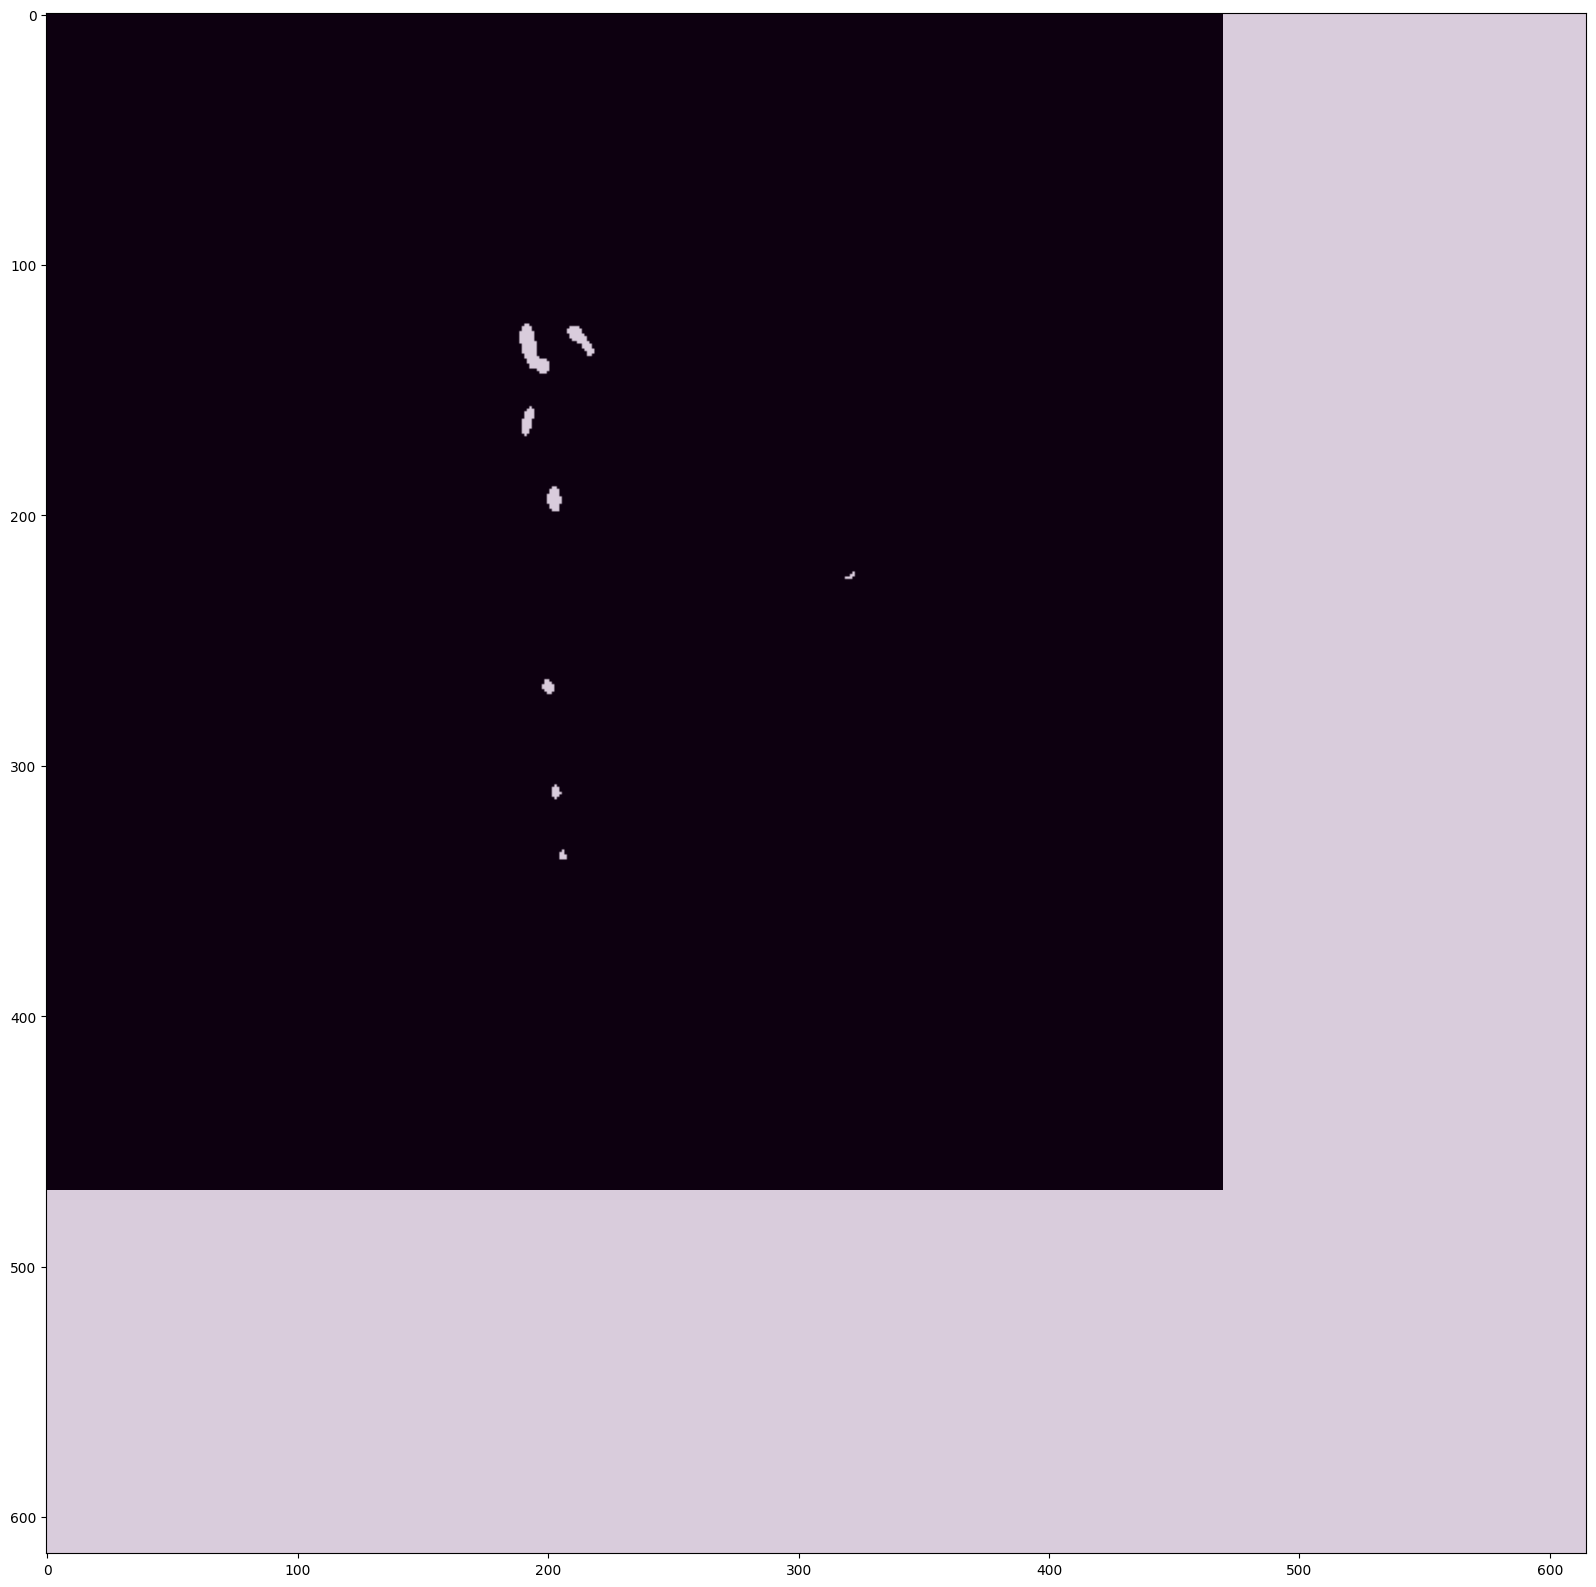

In [45]:
idx = 300
fig = plt.figure(figsize=(20, 20))
plt.imshow(vessel[idx], cmap="gray")
# plot with transparency for zeros
plt.imshow(new_mask[idx] * 10, cmap="viridis", alpha=0.2, vmax=20)
# plt.imshow(new_mask[idx], cmap="viridis", vmax=20)

In [59]:
sitk.WriteImage(output, f"pred_8_{layer}.nii.gz")
sitk.WriteImage(mask_header, "gt_8.nii.gz")

In [122]:
attention_weights[0][0].sum()

16.0

In [123]:
pred = sitk.GetArrayFromImage(output)
pred.min(), pred.max()

(0, 255)

In [171]:
np.unique(pred)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  13,  18,
        22,  25,  29,  32,  42, 255], dtype=uint16)

0

In [34]:
output

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7f5f82754540> >

In [ ]:
# create uniform grid of points of size 16x16
size = 16
smol = 4
grid = torch.zeros((smol, smol, 2))
for i in range(smol):
    for j in range(smol):
        grid[i, j, 0] = i
        grid[i, j, 1] = j
grid = grid / smol

u_1 = grid[:, :, 0].flatten()
u_2 = grid[:, :, 1].flatten()
n_heads = size
n_levels = 4
n_points = 32
# u_1 = torch.arange(n_heads, dtype=torch.float32) / n_heads
# u_2 = torch.arange(n_heads, dtype=torch.float32) / n_heads

z = 2 * u_1 - 1
x = torch.sqrt(1 - z**2) * torch.cos(2 * math.pi * u_2)
y = torch.sqrt(1 - z**2) * torch.sin(2 * math.pi * u_2)
# HACK: should fix hack of using cosine for third dim
grid_init_orig = torch.stack(
    [z, x, y],
    -1,
)

grid_init = (
    (grid_init_orig / grid_init_orig.abs().max(-1, keepdim=True)[0])
    .view(n_heads, 1, 1, 3)
    .repeat(1, n_levels, n_points, 1)
)
for i in range(n_points):
    grid_init[:, :, i, :] *= i + 1
grid_init.shape
sampling_offsets = nn.Linear(384, n_heads * n_levels * n_points * 3)
constant_(sampling_offsets.weight.data, 0.0)
sampling_offsets.bias = nn.Parameter(grid_init.view(-1))
bsz = 1
input_data = torch.randn(bsz, 384)
sampling = sampling_offsets(input_data)
sampling = sampling.view(bsz, n_heads, n_levels, n_points, 3)
sampling_flat = sampling.view(-1, 3).detach().numpy()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    sampling_flat[:, 0], sampling_flat[:, 1], sampling_flat[:, 2], c="b", marker="o"
)
grid_flat = grid_init.view(-1, 3)
# plot  3d
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(grid_flat[:, 0], grid_flat[:, 1], grid_flat[:, 2], c="b", marker="o")

In [15]:
meta = {}
for file in tqdm(val_im_files):
    header = sitk.ReadImage(file)
    idx = os.path.split(file)[1]
    meta[idx] = {
        "origin": list(header.GetOrigin()),
        "spacing": list(header.GetSpacing()),
    }
    # break

100%|██████████| 152/152 [04:30<00:00,  1.78s/it]


In [17]:
with open("./internal_test_meta.json", "w") as f:
    json.dump(meta, f)

In [4]:
val_df = pd.read_csv(val_box_path)

In [5]:
i  = 10
im_file = val_im_files[i]
mask_file = test_mask_files[i]
series_uid = os.path.split(im_file)[1]
print(series_uid)
series_box = val_df[val_df.seriesuid==series_uid]
series_box.head()

Ts0011.nii.gz


,seriesuid,coordX,coordY,coordZ,w,h,d,lesion
5,Ts0011.nii.gz,-35.503906,-172.082031,-165.09877,24.445312,26.773438,55.601273,aneurysm


In [6]:
mask_header = sitk.ReadImage(mask_file)
mask = sitk.GetArrayFromImage(mask_header)
img_header = sitk.ReadImage(im_file)
img = sitk.GetArrayFromImage(img_header)
print(mask.max(), mask.min(), mask.shape)
print(img.max(), img.min(), img.shape)

1 0 (380, 512, 512)
3071 -1024 (380, 512, 512)


In [7]:
new_mask = np.zeros_like(mask)
new_mask[100:200,200:300,150:200] = 1

In [ ]:
def make_prediction_file(gt_mask_header, gt_mask, bboxes):
    new_mask = np.zeros_like(mask)
    new_mask[100:200,200:300,150:200] = 1
    new_header = sitk.GetImageFromArray(new_mask)
    new_header.CopyInformation(mask_header)
    
    return new_header

In [13]:
new_header = sitk.GetImageFromArray(new_mask)

In [15]:
new_header.CopyInformation(mask_header)

In [17]:
sitk.WriteImage(new_header, "test.nii.gz")

In [16]:
new_header.GetOrigin()

(-148.708984375, -320.208984375, -219.10000610351562)

In [18]:
mask_header.GetSpacing()

(0.58203125, 0.58203125, 0.4000091552734375)

In [19]:
135/0.4

337.5

In [21]:
z = mask.sum(axis=(1,2))
z.shape

(380,)

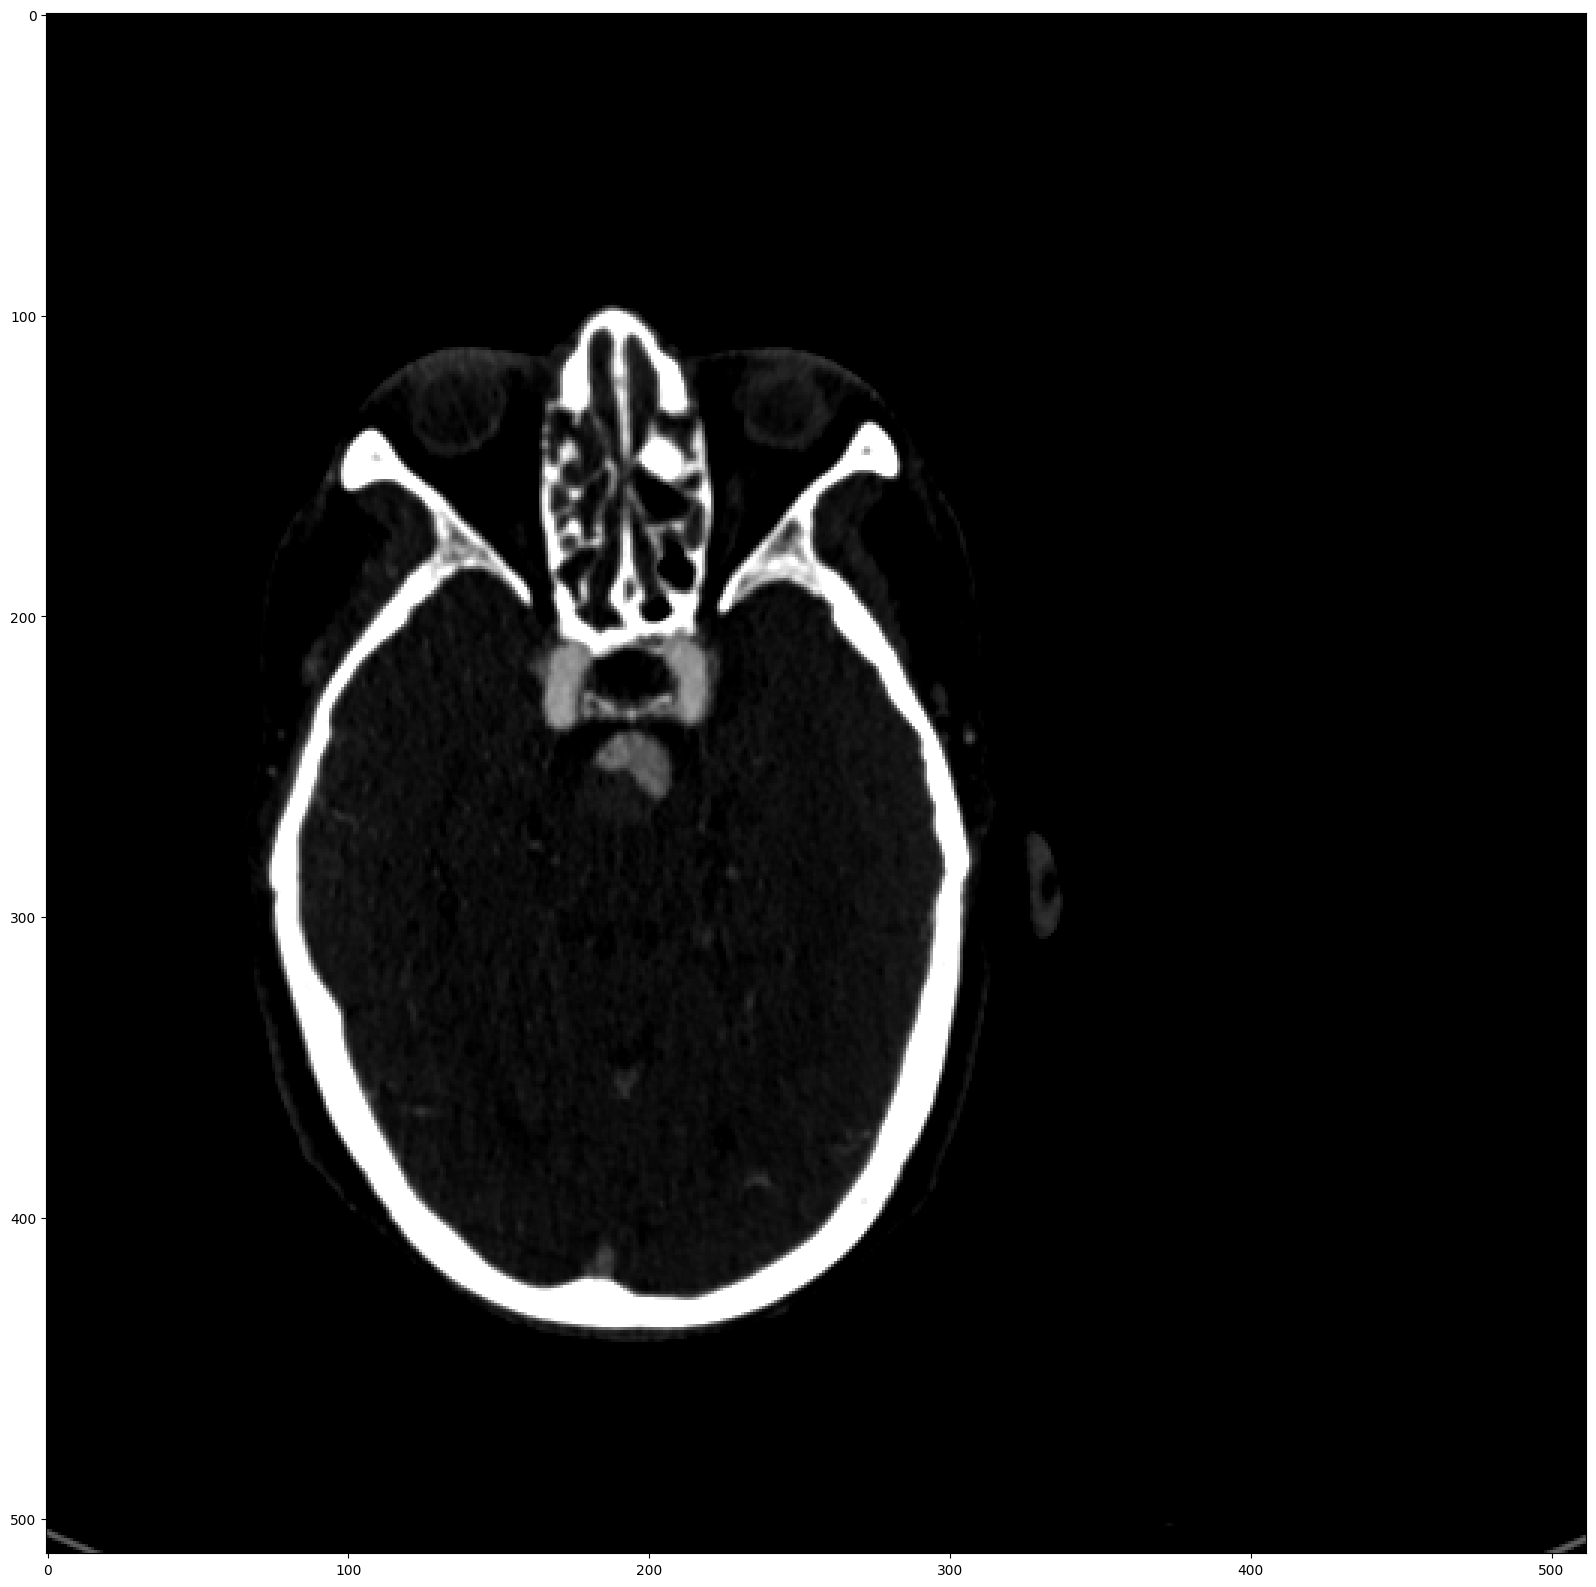

In [26]:
clip_img = apply_window(img[135])
show(clip_img)

In [29]:
img_header.TransformPhysicalPointToContinuousIndex()

(257.2181208053691, 551.8758389261745, 550.2374213236697)

In [28]:
mask_header.GetSpacing()

(0.58203125, 0.58203125, 0.4000091552734375)

In [30]:
mask_header.GetOrigin() + np.array([512,512,380])*mask_header.GetSpacing()

(-148.708984375, -320.208984375, -219.10000610351562)

In [31]:
(np.array([1.,1.,1.]) - mask_header.GetOrigin()) / mask_header.GetSpacing()

array([257.21812081, 551.87583893, 550.23742132])

In [34]:
img_header.TransformContinuousIndexToPhysicalPoint([1.,1.,1.])

(-148.126953125, -319.626953125, -218.6999969482422)

In [33]:
a ,b,c = img_header.GetSpacing()
a,b,c

(0.58203125, 0.58203125, 0.4000091552734375)

In [42]:
pred_file = "/work/vig/hieu/cta/CPMNetv2/work/vig/hieu/cta/outputs/gn/predict_epoch_0.csv"
data_dir = "/work/vig/Datasets/aneurysm/internal_test_0.4"
from tqdm import tqdm
pred_df = pd.read_csv(pred_file)
preds = {}
for seriesuid, rows in tqdm(pred_df.groupby("seriesuid")):
    img_header = sitk.ReadImage(f"{data_dir}/{seriesuid}")
    # rows = rows[rows.probability >= thres]
    pred = np.array(rows[["coordX","coordY","coordZ","w", "h", "d", "probability"]])
    res = []
    for point in pred:
    # convert pixel coordinate to world coordinate
        center = img_header.TransformContinuousIndexToPhysicalPoint(point[:3])
        size = point[3:-1]*np.array(img_header.GetSpacing())
        res.append(np.concatenate([np.array(center), size, point[-1:]], axis=0))
    preds[seriesuid] = np.stack(res, axis=0)

100%|██████████| 152/152 [04:56<00:00,  1.95s/it]


In [45]:
res = []
for series_uid, boxes in preds.items():
    for box in boxes:
        res.append({
            "seriesuid": series_uid,
            "coordX": float(box[0]),
            "coordY": float(box[1]),
            "coordZ": float(box[2]),
            "w": float(box[3]),
            "h": float(box[4]),
            "d": float(box[5]),
            "probability": float(box[6]),
        })

In [46]:
df = pd.DataFrame(res)
df.to_csv("prediction.csv", index=False)

In [49]:
111/126

0.8809523809523809

In [18]:
import pandas as pd
pred_df = pd.read_csv("/work/vig/hieu/cta/prediction.csv")
pred_df.head()

,seriesuid,coordX,coordY,coordZ,w,h,d,probability
0,Ts0001.nii.gz,-1.119921,-133.402657,-14.591070,5.841810,5.988140,5.310094,0.834791
1,Ts0001.nii.gz,-21.178161,-143.976949,-104.810368,2.898456,2.623842,2.402339,0.802601
2,Ts0001.nii.gz,7.197239,-65.701720,-146.612848,3.662061,3.548492,3.992772,0.728662
3,Ts0001.nii.gz,-119.228585,-105.127464,-180.097089,3.715757,3.497376,3.304313,0.714316
4,Ts0001.nii.gz,17.490239,-119.009653,-71.142207,4.378890,4.293246,3.836658,0.712115


In [77]:
seriesuid = "Ts0014.nii.gz"


In [78]:
gt_df = pd.read_csv("/work/vig/hieu/cta/test0.4.csv")
gt_df = gt_df[gt_df.seriesuid == seriesuid]
print(gt_df.shape)
gt_df.head()

(2, 8)


,seriesuid,coordX,coordY,coordZ,w,h,d,lesion
8,Ts0014.nii.gz,-23.955858,-170.555858,-885.999999,5.2,4.4,4.8,aneurysm
9,Ts0014.nii.gz,42.044143,-156.555858,-879.799999,11.6,12.4,10.0,aneurysm


In [79]:
df = pred_df[pred_df.seriesuid == seriesuid]
df = df[df.probability > 0.78]
print(df.shape)
df.head()

(3, 8)


,seriesuid,coordX,coordY,coordZ,w,h,d,probability
520,Ts0014.nii.gz,41.764455,-156.481506,-879.779583,9.938124,10.099691,9.005170,0.928080
521,Ts0014.nii.gz,-24.086698,-171.169134,-885.934719,3.969732,3.751293,3.030170,0.922311
522,Ts0014.nii.gz,35.636967,-142.203513,-874.239539,3.911783,3.692393,2.991862,0.837473


In [80]:
def make_prediction_file(gt_mask_header, gt_mask, bboxes):
    """
    bboxes [ccx cy cz, whd] in world coordinate
    """
    new_mask = np.zeros_like(gt_mask)
    for i, box in enumerate(bboxes, 2):
        pixel_center = gt_mask_header.TransformPhysicalPointToContinuousIndex(box[:3])
        scale = box[3:]/gt_mask_header.GetSpacing()
        x1, y1, z1 = np.floor(pixel_center-scale/2).astype(np.int32)
        x2, y2, z2 = np.ceil(pixel_center+scale/2).astype(np.int32)
        new_mask[z1:z2, y1:y2, x1:x2] = i

    new_header = sitk.GetImageFromArray(new_mask)
    new_header.CopyInformation(gt_mask_header)
    
    return new_header

In [81]:
gt_mask_header = sitk.ReadImage(f"/work/vig/Datasets/aneurysm/internal_test/og_0.4_label/{seriesuid}")
gt_mask = sitk.GetArrayFromImage(gt_mask_header)
boxes = np.array(df[["coordX","coordY","coordZ","w", "h", "d"]])
boxes.shape

(3, 6)

In [82]:
output = make_prediction_file(gt_mask_header, gt_mask, boxes)

In [83]:
sitk.WriteImage(output, f"pred_{seriesuid}")

In [39]:
import torch
import matplotlib.pyplot as plt

def show_img(img, cmap=None):
    plt.close()
    plt.imshow(img,cmap=cmap)
    plt.show()

['2.96', '23.42', '24.31']
['12.84', '22.35', '19.24']
1127 1 0


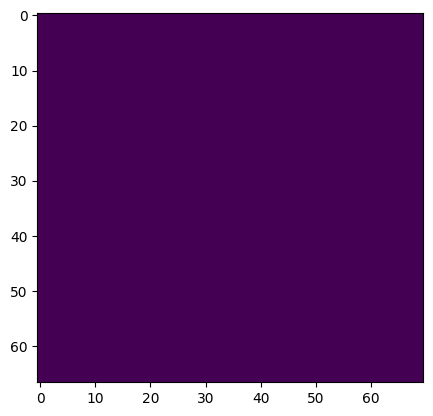

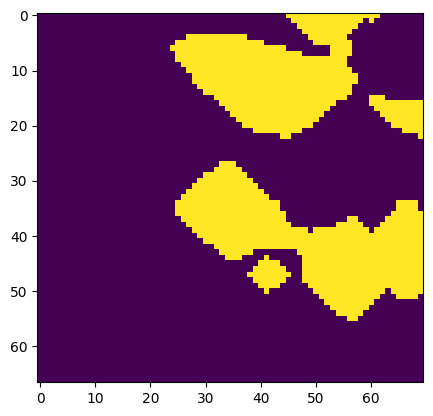

['34.06', '11.99', '36.86']
['13.02', '21.96', '20.72']
1506 1 0


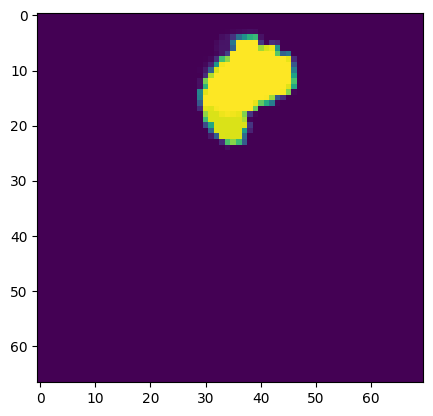

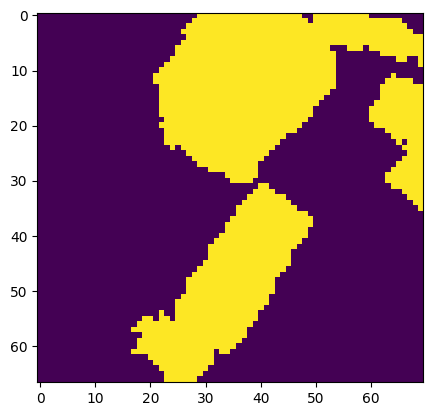

['34.06', '11.99', '36.86']
['13.02', '21.96', '20.72']
1506 1 0


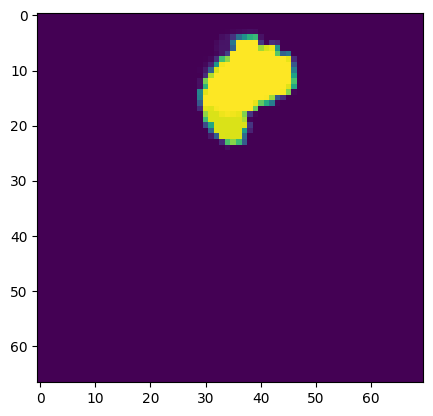

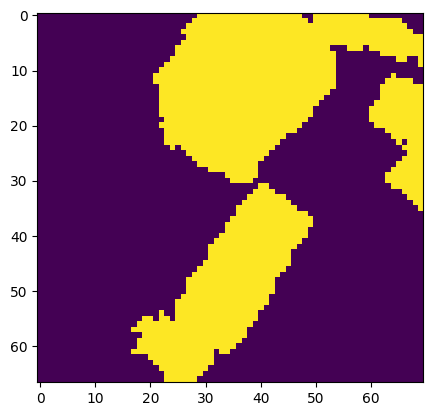

['2.96', '23.42', '24.31']
['12.84', '22.35', '19.24']
1127 1 0


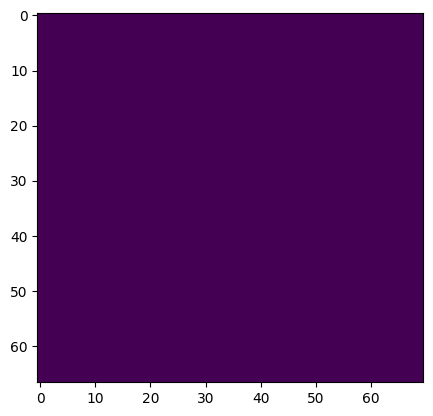

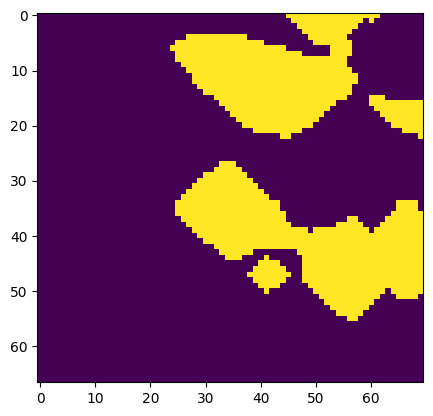

In [7]:
id = 34
for x in a:
    print([f"{v:.2f}" for v in x["ctr"][0]])
    print([f"{v:.2f}" for v in x["rad"][0]])
    print(x["mask"][0,id].sum(), x["mask"][0,id].max(), x["mask"][0,id].min())
    show_img(x["image"][0,id])
    show_img(x["mask"][0,id])

In [2]:
a  = torch.load("./CPMNetv2/debug.pth")


In [18]:
[x["image"].shape for x in a]


[(1, 64, 64, 64), (1, 64, 64, 64)]

In [8]:
a[0]["image"].shape

(1, 56, 55, 59)

[[ 2.96274035 23.41699125 24.3055481 ]]
[[12.83854203 22.35258374 19.24189172]]
1838 1 0


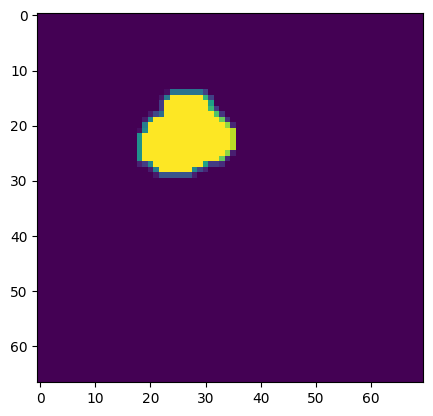

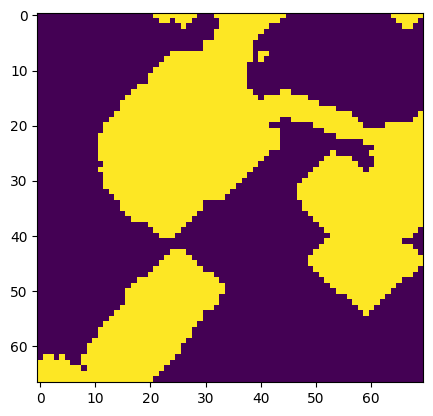

[[34.05673881 11.98765033 36.86168033]]
[[13.02169477 21.95946105 20.71632967]]
1761 1 0


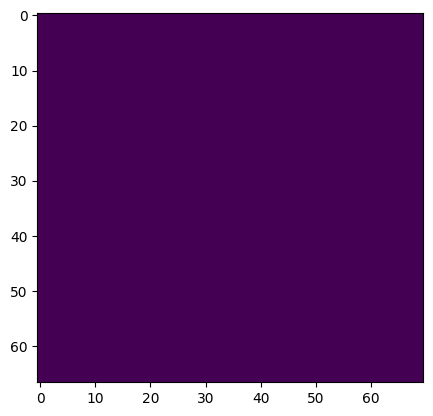

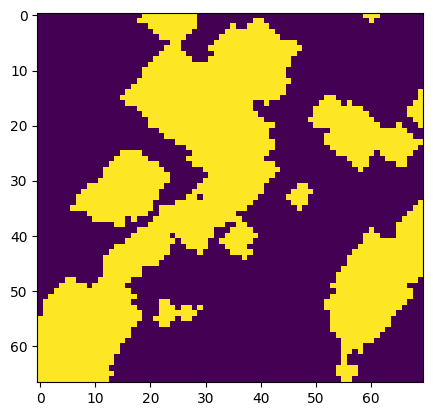

[[34.05673881 11.98765033 36.86168033]]
[[13.02169477 21.95946105 20.71632967]]
1761 1 0


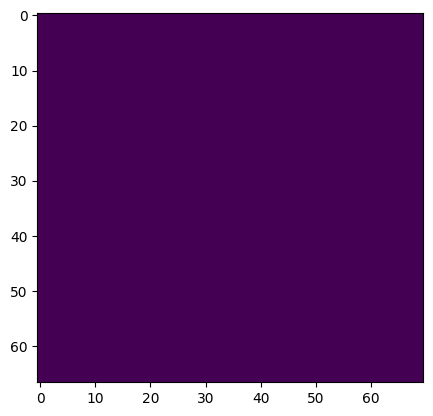

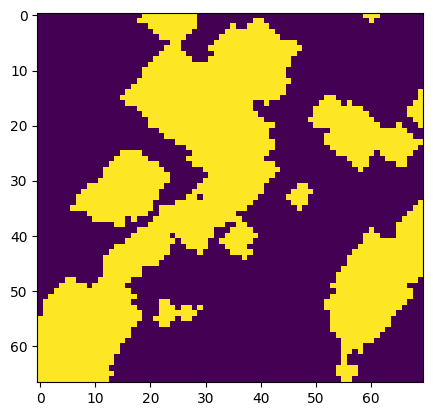

[[ 2.96274035 23.41699125 24.3055481 ]]
[[12.83854203 22.35258374 19.24189172]]
1838 1 0


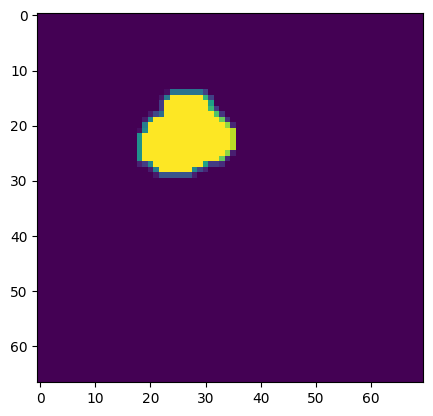

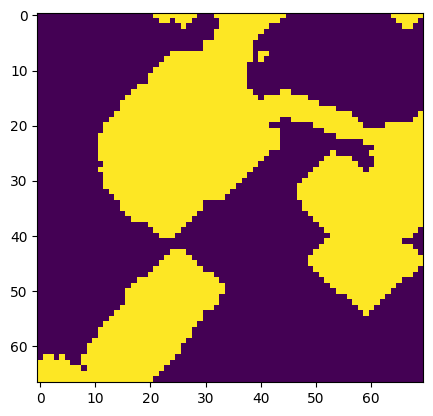

In [8]:
id = 2
for x in a:
    print(x["ctr"])
    print(x["rad"])
    print(x["mask"][0,id].sum(), x["mask"][0,id].max(), x["mask"][0,id].min())
    show_img(x["image"][0,id])
    show_img(x["mask"][0,id])

['2.96', '39.58', '44.69']
['12.84', '22.35', '19.24']
0 0 0


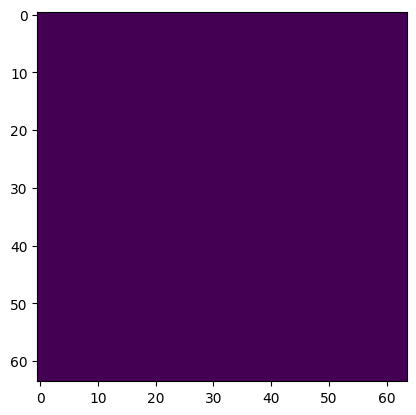

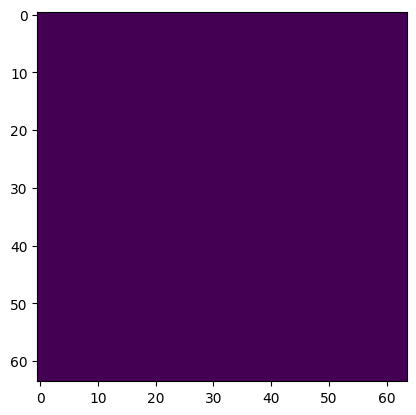

['34.06', '54.01', '27.14']
['13.02', '21.96', '20.72']
449 1 0


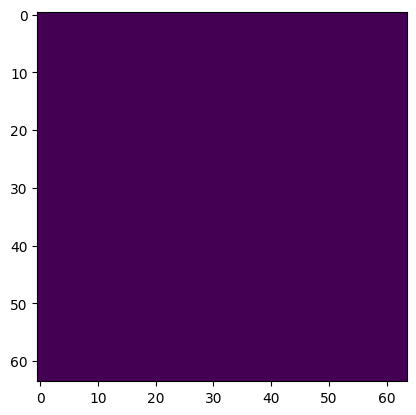

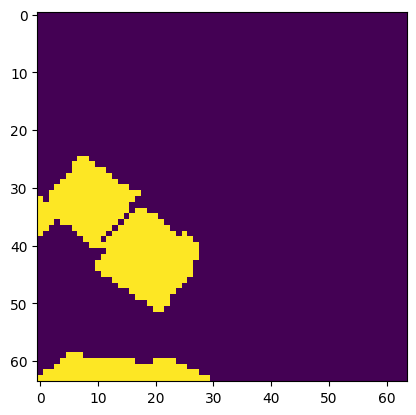

['34.06', '10.99', '31.86']
['13.02', '21.96', '20.72']
574 1 0


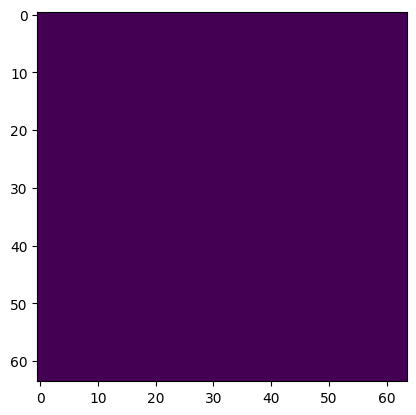

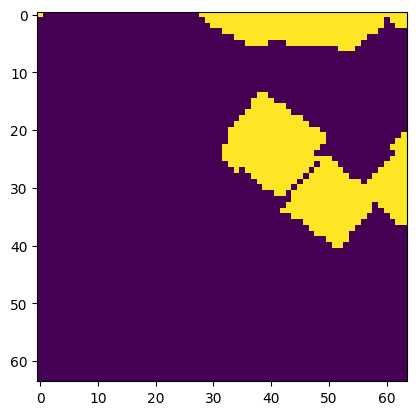

['60.04', '22.31', '22.42']
['12.84', '19.24', '22.35']
1726 1 0


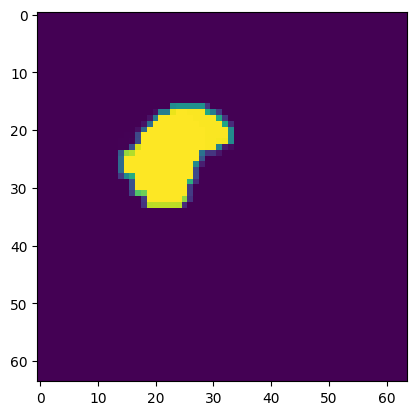

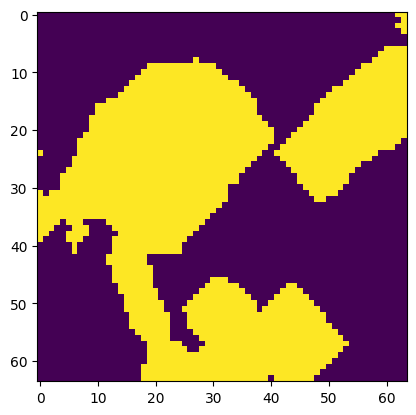

['59.00', '61.00', '58.00']
['13.00', '19.00', '21.00']
2083 1 0


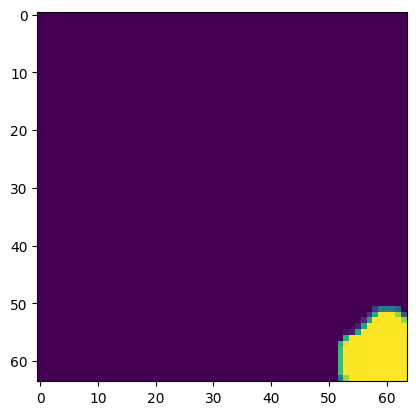

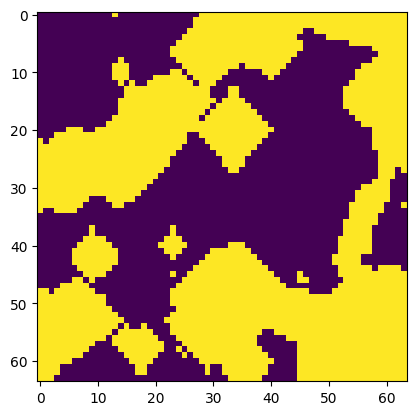

['34.06', '52.01', '30.14']
['13.02', '21.96', '20.72']
556 1 0


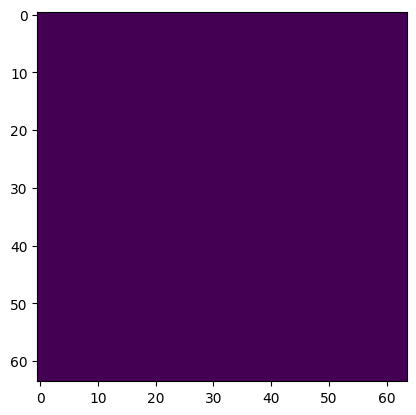

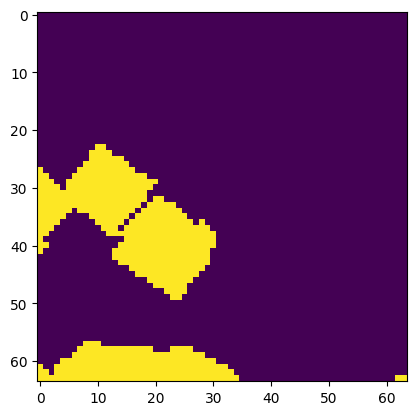

In [9]:
id = 60
b  = torch.load("./CPMNetv2/debug2.pth")
for x in b:
    print([f"{v:.2f}" for v in x["ctr"][0]])
    print([f"{v:.2f}" for v in x["rad"][0]])
    print(x["mask"][0,id].sum(), x["mask"][0,id].max(), x["mask"][0,id].min())
    show_img(x["image"][0,id])
    show_img(x["mask"][0,id])

In [26]:
from typing import List
import numpy as np
def sphere(r=1):
    x = np.arange(2*r+1).reshape(1,1,-1)-r
    y = np.arange(2*r+1).reshape(1,-1,1)-r
    z = np.arange(2*r+1).reshape(-1,1,1)-r
    distance = np.sqrt(x*x+y*y+z*z)
    return distance<=r

def make_dummy_data(input_size:List=[96,96,96], num_samples:int=16, sphere_per_sample=2, sparsity=0.1, max_r=20, seed=0):
    r = np.random.default_rng(seed=seed)
    size = tuple([num_samples] + input_size)
    
    data = r.random(size=size)*2 - 1
    sphs = r.random(size=(num_samples, sphere_per_sample, 4)) # 2 sphere per sample, center and radius
    mask = r.random(size=size) < sparsity
    # mask = scipy.ndimage.binary_dilation(mask, iterations=7)
    
    annotations = np.zeros(shape=(num_samples,sphere_per_sample,7), dtype=np.float32)
    for i, sph_i in enumerate(sphs):
        for j, sph_ij in enumerate(sph_i):
            radius = sph_ij[-1]*max_r
            i_r = int(radius)
            center = (sph_ij[:3]*(np.array(input_size)-2*radius))+radius
            i_center = center.astype(np.int32)
            sph_mask = sphere(i_r)
            mask[i][
                i_center[0]-i_r:i_center[0]+i_r+1,
                i_center[1]-i_r:i_center[1]+i_r+1,
                i_center[2]-i_r:i_center[2]+i_r+1,
            ] = np.logical_or(mask[i][
                i_center[0]-i_r:i_center[0]+i_r+1,
                i_center[1]-i_r:i_center[1]+i_r+1,
                i_center[2]-i_r:i_center[2]+i_r+1,
            ], sph_mask)
            annotations[i,j,:3] = center
            annotations[i,j,3:6] = radius
    # data = torch.tensor(data).unsqueeze(1)
    # annotations = torch.tensor(annotations).cuda()
    # mask = torch.tensor(mask)
    return mask, data, annotations

In [36]:
mask, data, annotations = make_dummy_data([64,64,64], sphere_per_sample=3)


['31.85', '31.39', '21.10', '19.16', '19.16', '19.16', '0.00']


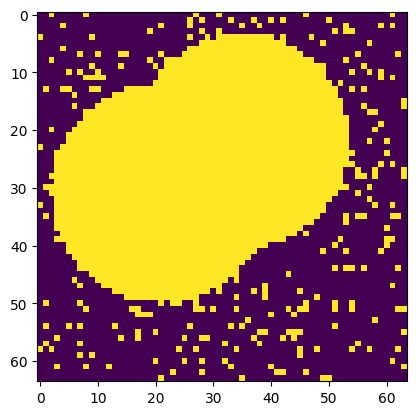

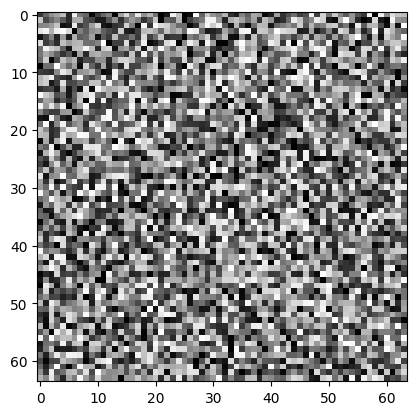

['13.51', '20.76', '38.40', '4.72', '4.72', '4.72', '0.00']


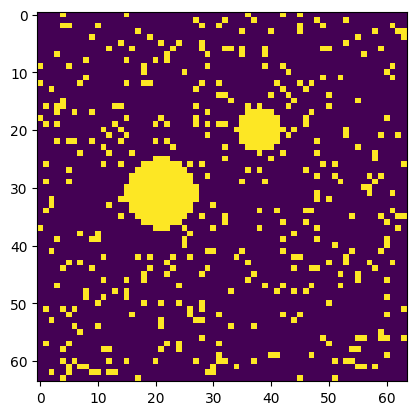

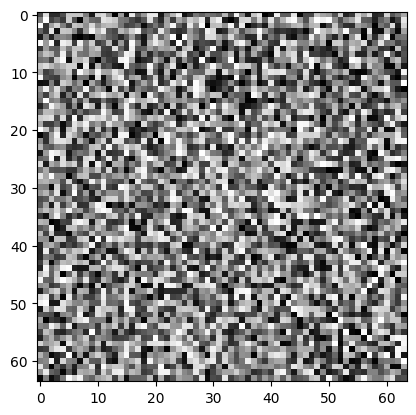

['35.10', '22.91', '35.01', '19.01', '19.01', '19.01', '0.00']


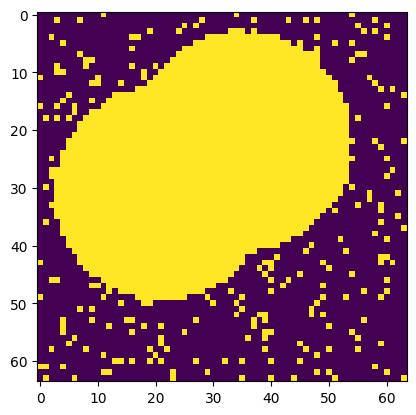

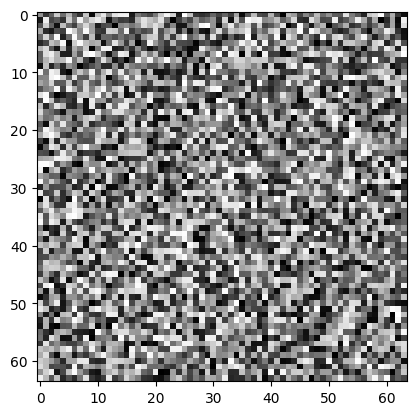

['57.20', '52.10', '26.82', '2.42', '2.42', '2.42', '0.00']


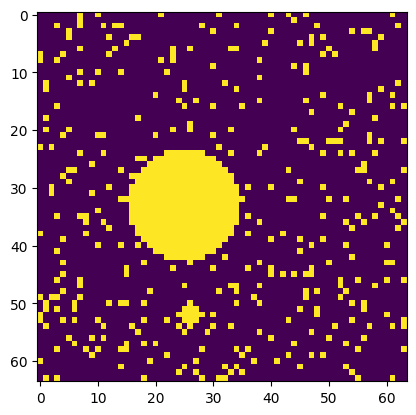

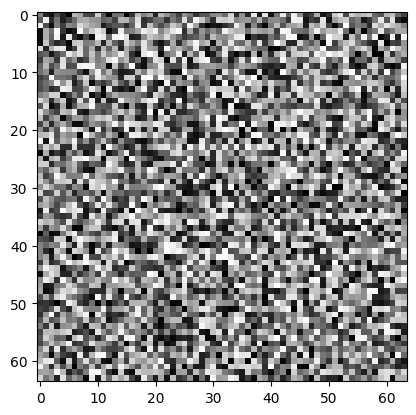

['16.58', '23.30', '17.21', '16.10', '16.10', '16.10', '0.00']


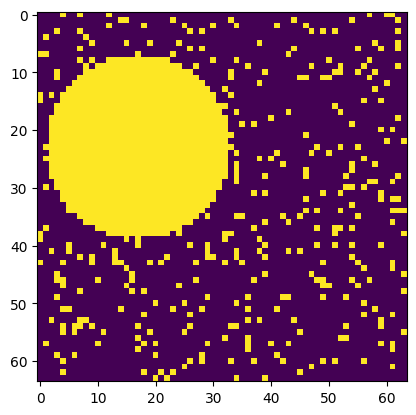

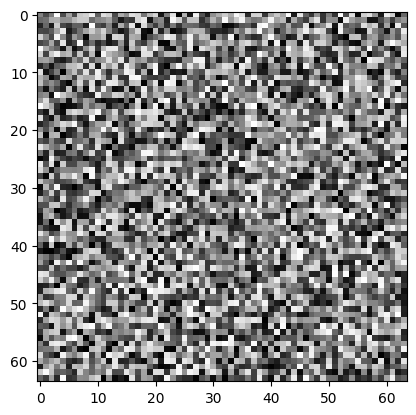

['43.88', '33.88', '25.08', '17.53', '17.53', '17.53', '0.00']


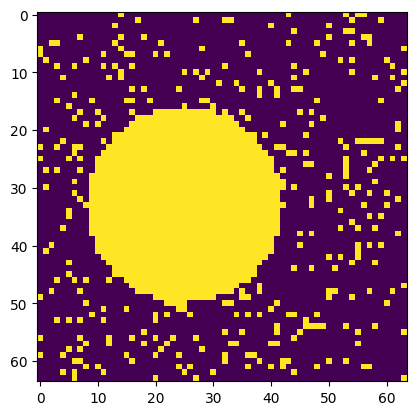

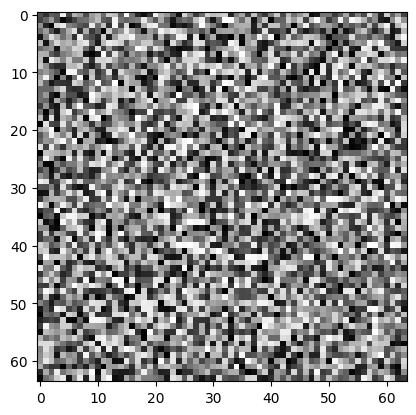

['38.26', '26.56', '35.33', '13.26', '13.26', '13.26', '0.00']


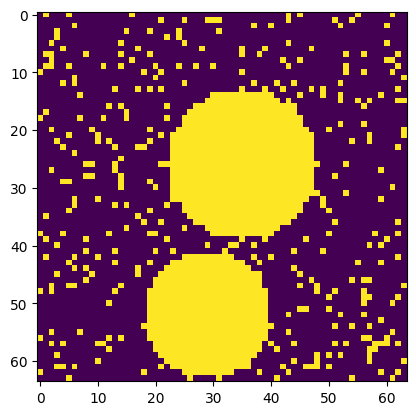

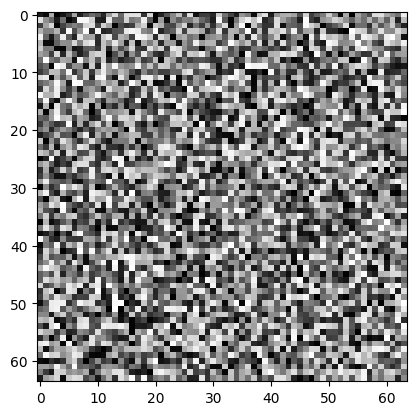

['18.77', '29.09', '24.64', '5.22', '5.22', '5.22', '0.00']


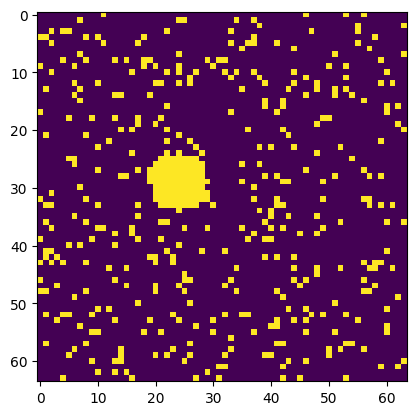

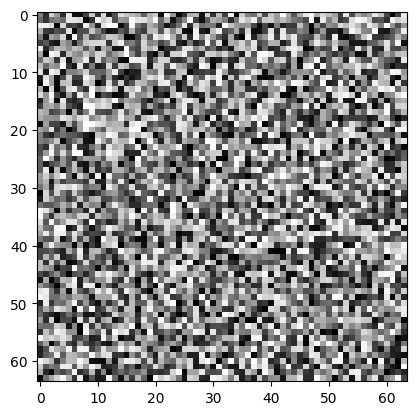

['40.79', '52.52', '29.21', '11.23', '11.23', '11.23', '0.00']


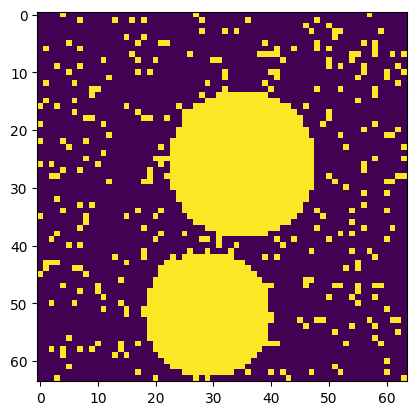

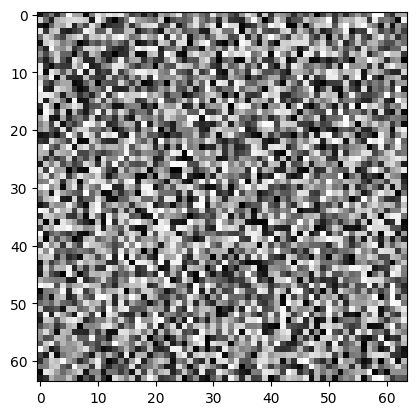

['50.31', '25.87', '16.69', '11.84', '11.84', '11.84', '0.00']


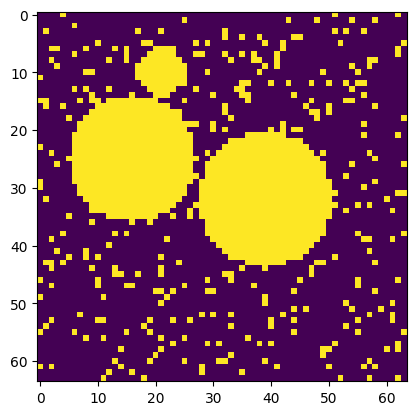

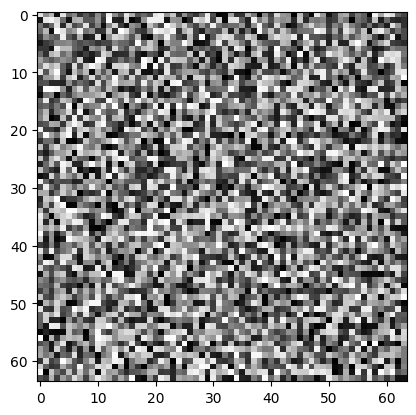

['42.27', '10.22', '21.57', '9.39', '9.39', '9.39', '0.00']


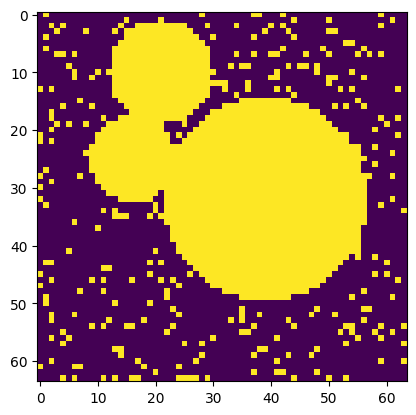

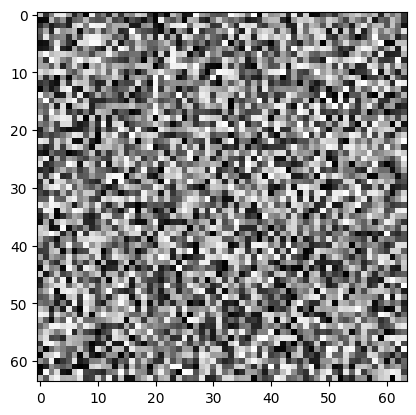

['35.82', '32.91', '39.09', '19.84', '19.84', '19.84', '0.00']


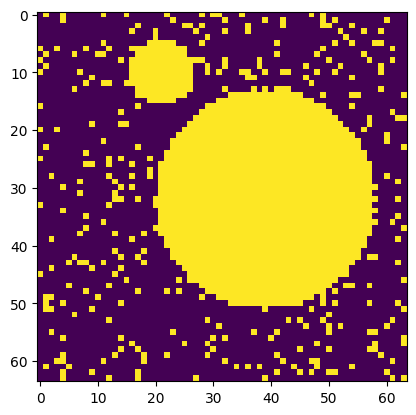

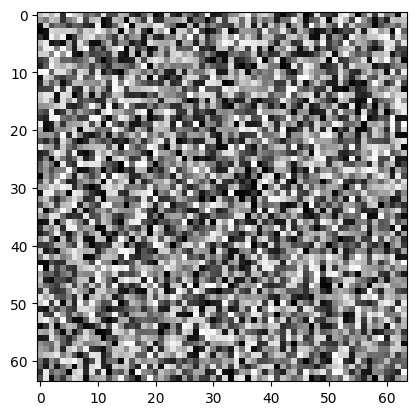

In [40]:
id = 32
for i in range(4):
    # print([f"{v:.2f}" for v in annotations[i]])
    for j in range(3):
        print([f"{v:.2f}" for v in annotations[i,j]])
        center = int(annotations[i,j,0])
    # print([f"{v:.2f}" for v in x["rad"][0]])
    # print(x["mask"][0,id].sum(), x["mask"][0,id].max(), x["mask"][0,id].min())
    # show_img(x["image"][0,id])
        show_img(mask[i,center])
        show_img(data[i,center], cmap="gray")